In [ ]:
pip install --upgrade tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, Conv2D
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/kidney_cleaned_dadaset.csv')

Mounted at /content/drive


In [ ]:
x = df.drop("classification", axis=1).values
y = df["classification"].values



In [ ]:
# Normalize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:

# Reshape to (samples, height, width, channels) to simulate image input
X_reshaped = x_scaled.reshape(x_scaled.shape[0], x_scaled.shape[1], 1, 1)

In [ ]:
feature_count = x_scaled.shape[1]
image_size = int(np.ceil(np.sqrt(feature_count)))  # Create square input
padded_features = np.zeros((x_scaled.shape[0], image_size**2))
padded_features[:, :feature_count] = x_scaled
x_image = padded_features.reshape(-1, image_size, image_size, 1)

In [ ]:

# Resize to MobileNet expected input size (224x224x3)
x_resized = tf.image.resize(x_image, [224, 224])
x_resized = tf.image.grayscale_to_rgb(x_resized)  # Convert 1 channel to 3

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_resized.numpy(), y, test_size=0.2, random_state=42)

In [ ]:
# Load MobileNetV2
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train,validation_split=0.2,epochs=30, batch_size=32,callbacks=[early_stop],verbose=1)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.6081 - loss: 0.6123 - val_accuracy: 0.9219 - val_loss: 0.3166
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9378 - loss: 0.2538 - val_accuracy: 0.9375 - val_loss: 0.1971
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9498 - loss: 0.1631 - val_accuracy: 0.8906 - val_loss: 0.2098
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9766 - loss: 0.1253 - val_accuracy: 0.9219 - val_loss: 0.1439
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9753 - loss: 0.0809 - val_accuracy: 0.9219 - val_loss: 0.1366
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9596 - loss: 0.0870 - val_accuracy: 0.9531 - val_loss: 0.1105
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9737 - loss: 0.0671 - val_accuracy: 0.9062 - val_loss: 0.1614
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9865 - loss: 0.0568 - val_accuracy: 0.9531 - val_loss: 0.0925
Epoch 9/

In [ ]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        28

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 1.0000 - loss: 0.0352
Test Accuracy: 1.00


In [ ]:
# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


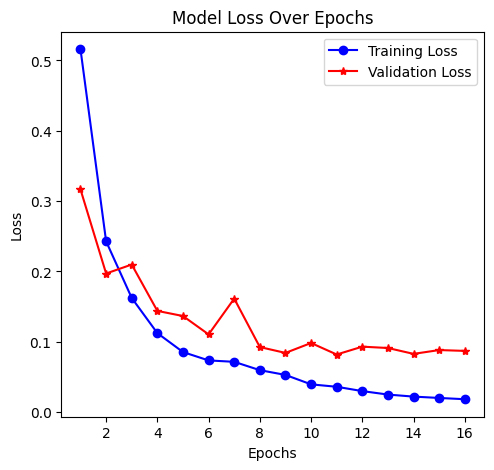

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

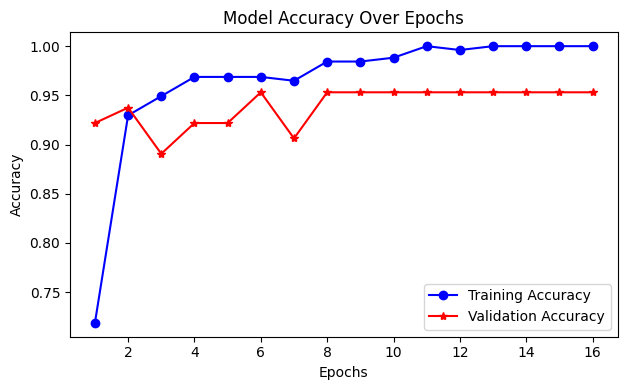

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


{'total_parameters': 2340033,
 'FLOPs': 612890241,
 'GFLOPs': 0.612890241,
 'model_size_bytes': 10556232,
 'model_size_MB': 10.067207336425781,
 'inference_time_seconds': 5.21142578125,
 'accuracy': 1.0}